
# Locating events within a constant velocity model

This example shows how to calculate the differential travel times of seismic
waves in a constant velocity model between two receivers. We first define the
model and the sources and receivers coordinates. We then calculate the travel
times for each receiver using the class
`covseisnet.travel_times.TravelTimes`, and we calculate the differential
travel times using the class
`covseisnet.travel_times.DifferentialTravelTimes`. Finally, we locate the
source of the seismic waves using the class
`covseisnet.backprojection.DifferentialBackProjection` and plot the
results on a map. 


In [5]:
from cartopy.crs import PlateCarree
import matplotlib.pyplot as plt

import covseisnet as csn
from covseisnet.travel_times import TravelTimes, DifferentialTravelTimes
from covseisnet.backprojection import DifferentialBackProjection

## Load seismograms

We first load the seismograms from the example data set. We downloaded the
seismogram from the Wilber 3 interface, [archived at this link](https://ds.iris.edu/wilber3/data_request/leonard-seydoux/2020-10-05-mb44-aegean-sea-1). These seismograms contains the record of the Mb 4.4 earthquake that occurred
in the Aegean Sea on October 5, 2020 at 14:57:51 UTC at 39.9°N, 23.3° E and
10 km depth.

We also pre-process the seismograms by merging overlapping traces, removing
the linear trend, filtering the data with a high-pass filter with a corner
frequency of 0.01 Hz, and synchronizing the traces, as shown in the other
examples.



In [6]:
# Load seismograms
stream = csn.NetworkStream.read("data/aegean_sea_example.mseed")

# Pre-process
stream.merge(1, fill_value=0)
stream.detrend("linear")
stream.filter("highpass", freq=0.01)
stream.synchronize()

## Station and source coordinates

We associate the coordinates of the different stations to the corresponding
seismograms. We first download the inventory of the seismograms from the
National Observatory of Athens (NOA) data center. We then associate the
coordinates to the seismograms using the method
:func:`~covseisnet.stream.Stream.assign_coordinates`. The
:class:`obspy.Inventory` object is then used to plot the stations on a map.

We also add the known source coordinates of the earthquake to the map, to
compare the location of the earthquake with the location of the
backprojection results.



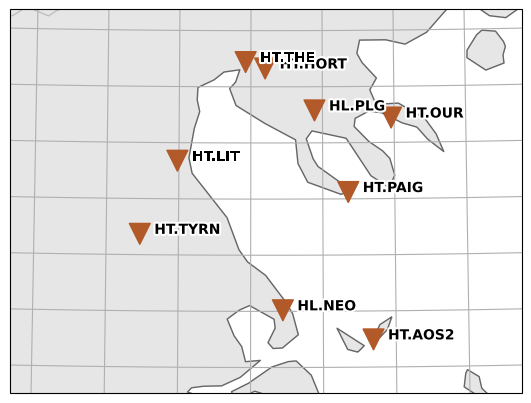

In [7]:
# Get inventory to assign station coordinates
inventory = stream.download_inventory(datacenter="NOA")
stream.assign_coordinates(inventory)
fig = inventory.plot(projection="local", resolution="h")

# Plot source coordinates
source_location = 23.3465, 39.8812, 10
fig.axes[0].plot(*source_location[:2], "k*", markersize=20, transform=PlateCarree())

# Extract natural extent for later use
extent = fig.axes[0].get_extent(crs=PlateCarree())

## Evaluate covariance matrix

We calculate the covariance matrix of the seismograms using the method
:func:`~covseisnet.covariance.calculate_covariance_matrix`. We use a window
duration of 200 s, which allow for the slowest possible seismic waves to
propagate between the stations (overestimating the travel time). We average
the covariance matrix over 5 windows, which results in a single time window.

In this specific case, the coherence is a function of the frequency only. We
observe the earthquake-related signal induces a strong wavefield coherence
(that is, a low spectral width) between 1 and 10 Hz in particular.



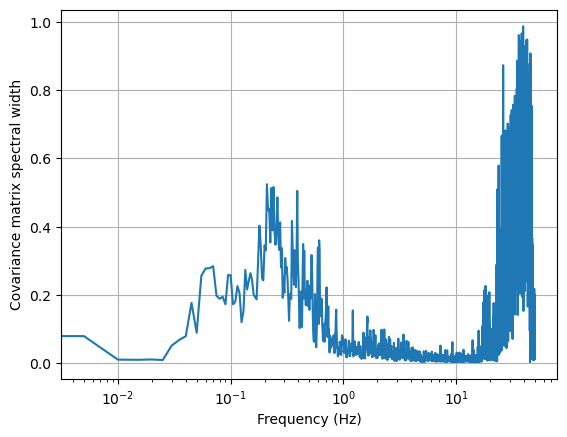

In [8]:
# Compute covariance matrix
times, frequencies, covariances = csn.covariance.calculate_covariance_matrix(
    stream, window_duration=200, average=5, whiten="none"
)

# Calculate coherence
coherence = covariances.coherence(kind="spectral_width")

# Show
fig, ax = plt.subplots()
ax.semilogx(frequencies, coherence.squeeze())
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Covariance matrix spectral width")
ax.grid()

## Evaluate the pairwise cross-correlation functions

We calculate the pairwise cross-correlation functions between the seismograms
using the method :func:`~covseisnet.correlation.calculate_cross_correlation_matrix`.
We exclude the autocorrelation functions from the calculation, as they are not
useful for the backprojection.

We also pre-process the cross-correlation functions by tapering the edges of
the functions, bandpass filtering the data between 1 and 5 Hz, calculating the
envelope of the data, and smoothing the data with a Gaussian filter with a
standard deviation of 30 samples. Finally, we normalize the data by the maximum
value of each cross-correlation function.



In [9]:
# Calculate cross-correlation functions
lags, pairs, correlations = csn.correlation.calculate_cross_correlation_matrix(
    covariances, include_autocorrelation=False
)


# Pre-process the cross-correlation functions
correlations = correlations.taper(0.1)
correlations = correlations.bandpass(frequency_band=(1, 5))
correlations = correlations.envelope()
correlations = correlations.smooth(sigma=30)
correlations /= correlations.max(axis=-1, keepdims=True)
correlations = correlations.squeeze()

## Calculate travel times

We calculate the travel times of the seismic waves between the stations using
the class :class:`~covseisnet.travel_times.TravelTimes`. We use a constant
velocity model with a velocity of 3.5 km/s, assuming that the S-waves will
dominate the seismic records. We then calculate the differential travel times
between the stations using the class
:class:`~covseisnet.travel_times.DifferentialTravelTimes`.



In [11]:
# Define the velocity model
extent_with_depth = extent + (-3, 20)

model = csn.velocity.VelocityModel(
    extent=extent_with_depth, shape=(40, 40, 40), velocity=3.5
)

# Obtain the travel times
travel_times = {
    trace.stats.station: TravelTimes(stats=trace.stats, velocity_model=model)
    for trace in stream
}

# Calculate differential travel times
differential_travel_times = {}
for pair in pairs:
    station_1, station_2 = pair
    differential_travel_times[pair] = DifferentialTravelTimes(
        travel_times[station_1],
        travel_times[station_2],
    )

## Locate the source with backprojection

We locate the source of the seismic waves using the class
:class:`~covseisnet.backprojection.DifferentialBackProjection`. We use the
differential travel times calculated previously and the pre-processed
cross-correlation functions. We calculate the likelihood of the source location
using the method :func:`~covseisnet.backprojection.DifferentialBackProjection.calculate_likelihood`.



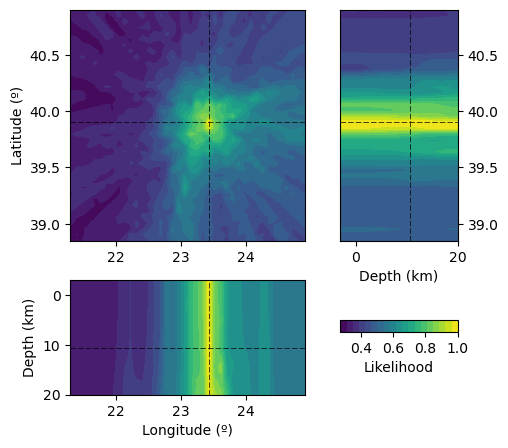

In [13]:
# Calculate likelihood
backprojection = DifferentialBackProjection(differential_travel_times)
backprojection.calculate_likelihood(cross_correlation=correlations)

# Plot likelihood in 3D
fig, ax = csn.plot.grid3d(backprojection, cmap="viridis", label="Likelihood")

## Compare maximum likelihood with known source location

The maximum likelihood of the source location is calculated using the method
:func:`~covseisnet.backprojection.DifferentialBackProjection.maximum_coordinates`.
We plot the source location and the maximum likelihood of the source location
on the map.



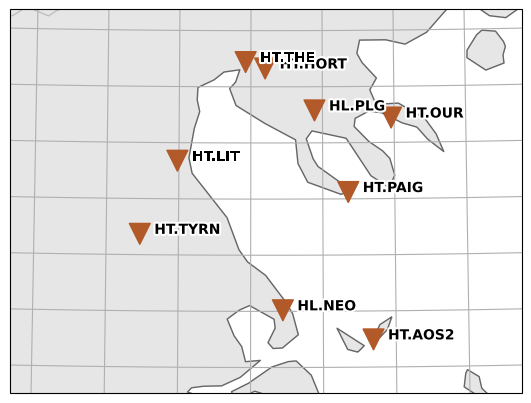

In [16]:
# Infer maximum coordinates
max_likelihood = backprojection.maximum_coordinates()

# Plot source and estimated location
fig = inventory.plot(projection="local", resolution="h")
fig.axes[0].plot(*source_location[:2], "k*", markersize=20, transform=PlateCarree())
fig.axes[0].plot(*max_likelihood[:2], "r*", markersize=20, transform=PlateCarree())